In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import LSTM , Dense , Embedding , Bidirectional
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [166]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [167]:
complaints_df = pd.read_csv("/gdrive/My Drive/CFG/cd_mumbai_complaints.csv")
category_df = pd.read_csv("/gdrive/My Drive/CFG/cd_categories.csv")

In [168]:
ids = list(category_df[category_df.parent_id == 0].id)
print(ids)

[1, 2, 4, 5, 6, 7, 9, 11, 15, 18, 19, 21, 22, 23, 168, 172, 313, 382, 454, 464, 470, 472, 473]


In [169]:
data_df = complaints_df[["created_at" , "category_id"]]
data_df = data_df.loc[data_df.category_id.isin(ids)]
print(data_df.head())

                                          created_at  category_id
0  We are facing multiple issues related to road ...         15.0
1  This is a really bad road. we need it cleaned ...          6.0
2                       This needs to be fixed asap.         21.0
3  We observed frequently heavy traffic at dahisa...         21.0
4  A pothole in front of Chand Shahwli Baba Darga...         15.0


In [170]:
data_df["created_at"] = data_df.created_at.astype("str")

In [171]:
data_df['created_at'] =data_df['created_at'].apply(lambda x: ' '.join([i.lower() for i in x.split()]))


In [172]:
data_df['created_at'] =data_df['created_at'].str.replace(r'[^\w\s]',"")


In [173]:
dico = {}
dico1 = open("/gdrive/My Drive/CFG/emnlp_dict.txt")
for word in dico1:
  # word = word.decode("utf-8")
  word = word.split()
  # print(word)
  dico[word[0]] = word[1]
dico1.close()

In [174]:
def txt_std(words):
    list_words = words.split()
    for i in range(len(list_words)):
        if list_words[i] in dico.keys():
            list_words[i] = dico[list_words[i]]
    return ' '.join(list_words)

In [175]:
data_df['created_at'] = data_df['created_at'].apply(txt_std)

In [176]:
data_df['created_at'] = data_df['created_at'].str.replace(r"xx+\s","")

In [177]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop = stopwords.words('english')
data_df['created_at'] =data_df['created_at'].apply(lambda x: ' '.join([i for i in x.split() if i not in stop]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from textblob import TextBlob
data_df['created_at'] =data_df['created_at'].apply(lambda x: str(TextBlob(x).correct()))

KeyboardInterrupt: ignored

In [178]:
from textblob import Word
nltk.download("wordnet")
data_df['created_at'] =data_df['created_at'].apply(lambda x:' '.join([Word(i).lemmatize() for i in x.split()]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [179]:
train_x, test_x, train_y, test_y = train_test_split(data_df['created_at'], data_df['category_id'], test_size=0.25)

In [180]:
tokenizer = Tokenizer(num_words = 25000)
tokenizer.fit_on_texts(train_x.values)
train_sequences = tokenizer.texts_to_sequences(train_x.values)
test_sequences = tokenizer.texts_to_sequences(test_x.values)
# print(sequences)
word_index = tokenizer.word_index# dictionary containing words and their index
print('Found %s unique tokens.' % len(word_index))

Found 5555 unique tokens.


In [184]:
import pickle

filehandle = open("/gdrive/My Drive/CFG/tokenizer" , "wb")
pickle.dump(tokenizer , filehandle)
filehandle.close()

In [ ]:
total_complaints = np.append(train_x.values,test_x.values)
MAX_SEQUENCE_LENGTH = max([len(c.split()) for c in total_complaints])
print(MAX_SEQUENCE_LENGTH)

217


In [ ]:
max_length = 217
EMBEDDING_DIM = 300
vocab_size = len(tokenizer.word_index)+1

In [ ]:
from keras.preprocessing.sequence import pad_sequences
train_data = pad_sequences(train_sequences, maxlen=max_length,padding='post')
test_data = pad_sequences(test_sequences, maxlen=max_length,padding='post')
print(train_data.shape)
print(test_data.shape)

(6945, 217)
(2316, 217)


In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
import os
import zipfile

# zip_ref = zipfile.ZipFile("/content/glove.6B.zip", 'r')
# zip_ref.extractall("/gdrive/My Drive/CFG/")
# zip_ref.close()


GLOVE_DIR = '/gdrive/My Drive/CFG/'
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
def get_model():
  model = Sequential()
  model.add(Embedding(len(word_index) + 1,
                              EMBEDDING_DIM,
                              weights=[embedding_matrix],
                              input_length=MAX_SEQUENCE_LENGTH,
                              trainable=True))
  model.add(Bidirectional(LSTM(100, dropout_U = 0.2, dropout_W = 0.2)))
  model.add(Dense(21,activation='softmax'))

  return model

In [ ]:
lstm_model = get_model()
lstm_model.compile(loss="categorical_crossentropy" , optimizer="rmsprop" , metrics=['acc'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, dropout=0.2, recurrent_dropout=0.2)`
  


In [ ]:
print(train_data.shape)
print(test_x.shape)

(6945, 217)
(2316,)


In [ ]:
# print(train_data.shape)
# from keras.utils import to_categorical

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()

# labels_train = to_categorical(np.asarray(train_y))
# labels_test = to_categorical(np.asarray(test_y))
# print(type(train_y))
enc = enc.fit( np.array(list(train_y) + list(test_y)).reshape(-1,1))

# labels_train = enc.fit_transform(np.array(train_y).reshape(-1,1))
labels_test = enc.transform(np.array(test_y).reshape(-1,1))
labels_train = enc.transform(np.array(train_y).reshape(-1,1))

print(train_y.shape)
print(labels_train.shape)
print(labels_test.shape)

(6945,)
(6945, 21)
(2316, 21)


In [ ]:
history = lstm_model.fit(train_data, labels_train, batch_size=64, epochs=10, validation_data=(test_data, labels_test))

Train on 6945 samples, validate on 2316 samples
Epoch 1/10
6945/6945 [==============================] - 134s 19ms/step - loss: 0.2331 - acc: 0.9391 - val_loss: 0.2117 - val_acc: 0.9404
Epoch 2/10
6945/6945 [==============================] - 132s 19ms/step - loss: 0.1918 - acc: 0.9502 - val_loss: 0.2008 - val_acc: 0.9400
Epoch 3/10
6945/6945 [==============================] - 133s 19ms/step - loss: 0.1640 - acc: 0.9558 - val_loss: 0.1938 - val_acc: 0.9439
Epoch 4/10
6945/6945 [==============================] - 132s 19ms/step - loss: 0.1360 - acc: 0.9616 - val_loss: 0.1877 - val_acc: 0.9499
Epoch 5/10
6945/6945 [==============================] - 132s 19ms/step - loss: 0.1117 - acc: 0.9689 - val_loss: 0.1948 - val_acc: 0.9491
Epoch 6/10
6945/6945 [==============================] - 132s 19ms/step - loss: 0.0949 - acc: 0.9745 - val_loss: 0.1902 - val_acc: 0.9482
Epoch 7/10
6945/6945 [==============================] - 131s 19ms/step - loss: 0.0765 - acc: 0.9816 - val_loss: 0.1962 - val_acc: 

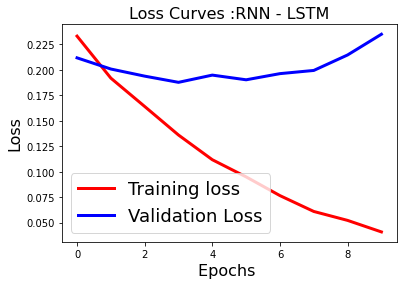

In [ ]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN - LSTM',fontsize=16)
plt.show()

In [ ]:
predicted = lstm_model.predict(test_data)
predicted

array([[4.8256169e-08, 9.8961230e-08, 4.0623661e-07, ..., 6.2502700e-08,
        4.4191415e-07, 3.2566905e-09],
       [4.3839243e-08, 1.4238853e-07, 2.3810914e-07, ..., 5.2313915e-08,
        1.9869469e-07, 4.9452016e-09],
       [5.4208119e-04, 4.3510780e-02, 6.2366127e-04, ..., 1.4697256e-03,
        1.1575726e-03, 1.8941300e-05],
       ...,
       [2.5603471e-08, 5.9863126e-08, 1.2770398e-07, ..., 2.6572009e-08,
        1.5421017e-07, 4.3166817e-09],
       [8.8592671e-08, 2.8822581e-07, 4.8052686e-07, ..., 9.8994136e-08,
        4.8487055e-07, 9.7644834e-09],
       [4.3839243e-08, 1.4238853e-07, 2.3810914e-07, ..., 5.2313915e-08,
        1.9869469e-07, 4.9452016e-09]], dtype=float32)

In [ ]:
lstm_model.save(filepath="/gdrive/My Drive/CFG/model")